In [1]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import functional as F
import numpy as np
from pycocotools.coco import COCO
import numpy as np
from typing import List, Dict, Tuple, Sequence, Any
from collections import Counter, defaultdict, OrderedDict
from itertools import chain
import random
random.seed(1234)
from dataset_test import Language, NMTDataset

import torch
import random
from PIL import Image
import torchvision.transforms as transforms
import time
import math
import os
from models import Encoder, Decoder, Decoder_test, Seq2seq_test
import matplotlib.pyplot as plt

In [2]:
dataDir='../coco'
test_dataType='test2017'
test_image_path = f'{dataDir}/images/{test_dataType}'

In [3]:
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])

In [63]:
embedding_size = 512
hidden_size = 1024
num_layers = 2
num_dirs = 2
dropout = 0.1

In [64]:
dataDir='../coco'
train_dataType='train2017'
annFile='{}/annotations/captions_{}.json'.format(dataDir,train_dataType)
train_coco=COCO(annFile)

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


In [65]:
train_imgIds = train_coco.getImgIds()
train_length = len(train_imgIds)*0.5
train_annIds = train_coco.getAnnIds(imgIds=train_imgIds[:int(train_length)])
train_anns = train_coco.loadAnns(train_annIds)

In [66]:
vocab = Language(train_anns)
vocab.build_vocab()
vocab_size = len(vocab.word2idx)
vocab_size

12578

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
encoder = Encoder(embedding_size)
decoder = Decoder_test(vocab_size, embedding_size, hidden_size)
seq2seq = Seq2seq_test(encoder, decoder, device)

In [69]:
seq2seq = seq2seq.to(device)

In [70]:
seq2seq.load_state_dict(torch.load("showandtell_0.5.pt").state_dict())
seq2seq.eval()
it = [x for x in range(100)]
s = iter(it)

000000396413.jpg


'a herd of elephants walking in a grassy field'

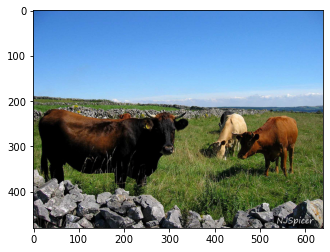

In [75]:
file_name = os.listdir(test_image_path)[next(s)+1000]
img = Image.open(f'{test_image_path}/{file_name}').convert('RGB')
print(file_name)
plt.imshow(img)
img = transform(img)
img = img.unsqueeze(0)
img = img.to(device)
sos = torch.tensor(2).view(1,1).to(device)
with torch.no_grad():
    out = seq2seq.sample(img, sos, [25])
    _, top_ids = torch.max(out, dim=-1)
sentence=[]
for word in top_ids:
    if word==3:
        break
    sentence.append(vocab.idx2word[word])
' '.join(sentence)

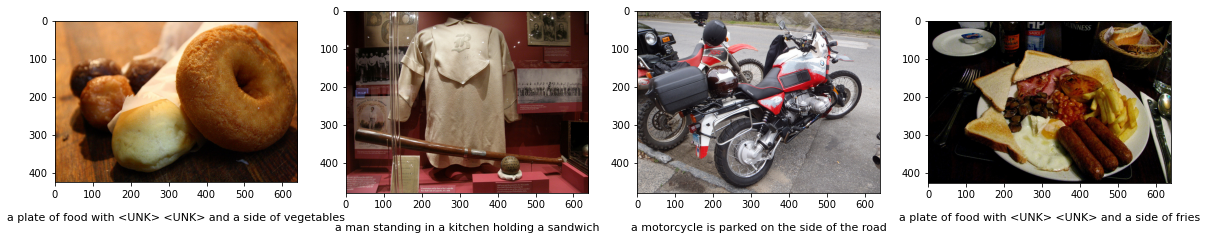

In [83]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(20, 10), facecolor='white')
fig
columns = 4
rows = 1

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(1,columns*rows+1):
    file_name = os.listdir(test_image_path)[next(s)+1000]
    img = Image.open(f'{test_image_path}/{file_name}').convert('RGB')
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img)
    w, h = img.size
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    sos = torch.tensor(2).view(1,1).to(device)
    with torch.no_grad():
        out = seq2seq.sample(img, sos, [25])
        _, top_ids = torch.max(out, dim=-1)
    sentence=[]
    for word in top_ids:
        if word==3:
            break
        sentence.append(vocab.idx2word[word])
    ax.text(w/2, h+100, ' '.join(sentence), ha='center', size = 11)